# Prophet
- **가산적 모델** 사용하는 것
- 시계열을 서로 다른 시간 단위(일/주/월/연간)패턴의 조합으로 전체 추세와 함께 나타냄 -> 페이스북 Prophet 이용!
- 변환점(행동의 급격한 변화), 휴일 등을 고려하는 고급 기능
- 장점: 시계열의 미래 값을 불확실성 수준을 나타내는 신뢰 구간과 함께 예측


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install prophet

In [4]:
# 라이브러리 불러오기
import pandas as pd
import seaborn as sns
from prophet import Prophet
import matplotlib.pyplot as plt

In [16]:
# 파일 경로
file_path = "/content/drive/MyDrive/🐹전종설🐹/코드/유진티비/Time Series Modeling/df_time_series.csv"

# 인코딩 방식 리스트
encodings = ['utf-8', 'euc-kr', 'latin1']

# 각 인코딩 방식으로 파일 열기 시도
df = None
for encoding in encodings:
    try:
        df = pd.read_csv(file_path, encoding=encoding)
        break
    except UnicodeDecodeError:
        continue

# 파일 열기 성공 여부 확인
if df is None:
    print("파일 열기에 실패했습니다.")
else:
    print("파일 열기 성공!")

df.head(5)

파일 열기 성공!


,일자,배출권 가격(종가)
0,2015-01-12,8640
1,2015-01-13,9500
2,2015-01-14,9510
3,2015-01-15,9580
4,2015-01-16,9610


In [23]:
# train/validation 데이터 나누기
df_train = df[df.일자 < '2021-01-01']
df_test = df[df.일자 >= '2021-01-01']

In [24]:
df_train = df_train
df_train.columns
df_train.rename(columns={'일자': 'ds', '배출권 가격(종가)': 'y'}, inplace=True)

<ipython-input-24-aaf4482e32b7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.rename(columns={'일자': 'ds', '배출권 가격(종가)': 'y'}, inplace=True)


In [25]:
df_test = df_test
df_test.columns
df_test.rename(columns={'일자': 'ds', '배출권 가격(종가)': 'y'}, inplace=True)

<ipython-input-25-70ed676806a1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.rename(columns={'일자': 'ds', '배출권 가격(종가)': 'y'}, inplace=True)


In [81]:
# 모델의 인스턴스를 만들고 데이터 적합
model_prophet = Prophet(seasonality_mode='additive')
model_prophet.add_country_holidays(country_name='KR')
model_prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_prophet.fit(df_train)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_olxdhy/z10lhixm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpz_olxdhy/bu28vxz2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96772', 'data', 'file=/tmp/tmpz_olxdhy/z10lhixm.json', 'init=/tmp/tmpz_olxdhy/bu28vxz2.json', 'output', 'file=/tmp/tmpz_olxdhy/prophet_modelz7f8fixi/prophet_model-20230608142634.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:26:34 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:26:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


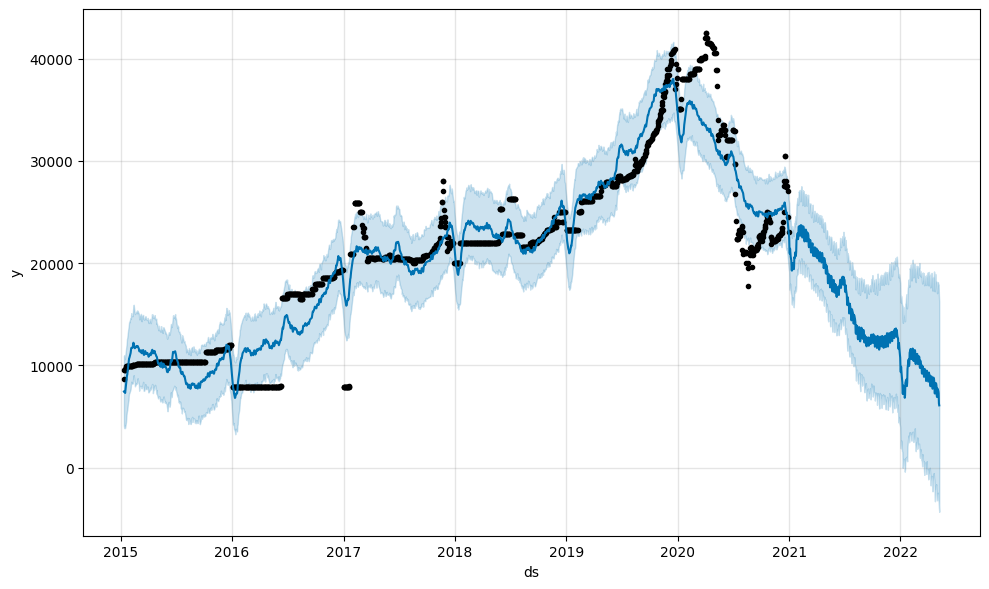

In [82]:
# 가격을 예측하고 결과를 도식화
df_future = model_prophet.make_future_dataframe(periods=494)
df_pred = model_prophet.predict(df_future)
model_prophet.plot(df_pred)

plt.tight_layout()
plt.show()

- 검은 점: 실제 관측값, 파란선: 적합화 (관측값과 정확히 일치x)
- 모델이 데이터의 노이즈를 평활화해서 제거했기 때문
- Prophet은 불확실성을 정량화 -> 적합선 주위의 파란색 간격

In [ ]:
# 시계열 분해 검사
model_prophet.plot_components(df_pred)

plt.tight_layout()
plt.show()

In [60]:
# 성능 평가

from sklearn.metrics import mean_squared_error
print('The RMSE Prophet is :', mean_squared_error(df_test.y.values, df_pred[1469:]['yhat'].values)**0.5)

The RMSE Prophet is : 12235.5666556122


In [106]:
# 테스트 집합을 예측 DataFrame과 병합
selected_columns = ['ds', 'yhat_lower', 'yhat_upper', 'yhat']

df_pred = df_pred.loc[:, selected_columns].reset_index(drop=True)
df_test = df_test.merge(df_pred, on=['ds'], how='left')
df_test.ds = pd.to_datetime(df_test.ds)
df_test.set_index('ds', inplace=True)
df_test.head()

,y,yhat_lower,yhat_upper,yhat
ds,,,,
2021-01-04,23000,17994.131683,24814.278956,21405.551423
2021-01-05,23000,17497.195630,24281.623999,20932.511567
2021-01-06,23000,17232.750471,24093.404784,20626.446583
2021-01-07,23000,17011.078526,23575.322369,20437.604573
2021-01-08,23000,16876.224300,23511.268489,20241.938895
